In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torch.onnx as onnx
import torchvision.models as models

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits




In [ ]:

model = NeuralNetwork()

learning_rate = 1e-3
batch_size = 64
epochs = 20

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= size
    correct /= size

    print(f"test error: \n accuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n")


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for t in range(epochs):
    print(f"epoch {t + 1}\n---------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("done !")


save pytorch model state to model.pth


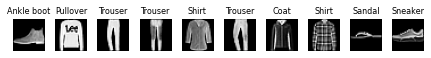

In [16]:
from matplotlib import pyplot as plt
torch.save(model.state_dict(), "model.pth")
print("save pytorch model state to model.pth")

model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
plt.figure()
for i in range(10):
    x, y  = test_data[i][0], test_data[i][1]
    img = x.reshape(28, 28)
    plt.subplot(1,10,i+1)
    plt.imshow(img, cmap = 'gray')
    plt.title(classes[y], size=8)
    plt.axis('off')
    plt.tight_layout()
plt.show()
    # with torch.no_grad():
    #     pred = model(x)
    #     print(f"pred's shape: {pred.shape}")
    #     predicted, actual = classes[pred[0].argmax(0)], classes[y]
    #     print(f'Predicted: "{predicted}", Actual: "{actual}"')